In [1098]:
import numpy as np
from QAM_EncoderDecoder import * 
import commpy
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
from scipy.signal import csd, chirp
import binascii
from scipy.signal import correlate
from IPython.display import Audio
%matplotlib inline

1. Create a block of pseudo-random constellation values
2. Add chirp at beginning and transmit OFDM block repeatedly
3. Convolve with inverse chirp to synchronise
4. Trim to just OFDM blocks
5. Average to block length n, take DFT, divide by tx constellation values to recover channel tf
6. Take iDFT to get impulse response of channel

In [1099]:
N = 1024 # for dft length, no symbols
prefix_no = 0
fs = 44100

#random_symbol = np.random.randint(0,100, int(N/4)) # easier to test if same every time
# NEED TO CHANGE TO PSEUDO RANDOM SIGNALS
random_symbol = np.array([81, 41, 51, 46, 19, 27, 84, 53,  0, 86, 54, 17, 33, 32,  8, 24, 19,
       38, 58, 28, 74, 10, 39, 24, 39, 22, 59, 58, 70, 74, 82, 64,  4, 77,
       98, 50, 26, 36, 21, 32, 56, 27, 92, 42, 63, 91, 67, 76, 65, 40, 17,
       49, 66, 42, 87, 20, 50, 89, 48, 47, 40, 29, 57, 40, 92, 73,  8, 26,
       12, 76, 24, 82, 43, 14, 40, 19, 56, 97, 78, 43, 96, 43, 89,  6, 11,
       98, 58, 25, 91, 16, 40, 77, 52,  9, 34, 45, 36, 69, 12, 29, 38, 45,
       88, 14, 20, 49,  1, 61, 48, 36, 10, 44, 44,  5,  7, 34, 26, 72,  7,
       63, 68, 27, 12, 71, 39, 54, 96,  1, 70, 67, 76, 30, 77, 73, 28, 88,
       31, 17, 86, 62,  1, 12, 35, 74,  3, 87, 73, 26, 83, 73,  6,  3, 32,
       37, 39, 53, 90, 88, 60, 89, 93, 91,  4, 53,  5,  4,  4, 58, 35, 63,
       27, 77, 51, 87, 24, 31, 16,  4, 87, 98, 52, 90, 68, 37, 75, 56, 34,
       30, 50, 26, 20, 96, 51, 94, 60, 55, 14, 74,  4, 73, 13, 45, 67,  8,
       61, 12, 93,  6, 87, 14, 90, 64, 33, 29, 68, 13, 60, 18,  9, 60,  3,
       15,  6, 48, 34, 44, 63, 25, 39, 18,  5, 56, 38, 46,  6, 64, 36, 29,
       90, 47, 23, 29, 97, 19,  5, 47, 30, 63, 98, 99, 20, 91, 69, 24, 35,
       59])

about to do encode_bitstr2symbols encoding
encode_bitstr2symbols encoding finished
512
513
1024
[ 0.23242188+0.j -0.17946095+0.j -0.0063764 +0.j ...  0.09341227+0.j
 -0.01054346+0.j  0.16528181+0.j]
(1, 1024)
[ 3.55271368e-15 +0.j -1.00000000e+01+10.j -1.00000000e+01+10.j ...
  1.00000000e+01-10.j -1.00000000e+01-10.j -1.00000000e+01-10.j]


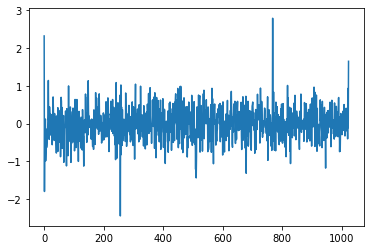

In [1100]:
bin_strings=''
for byte in random_symbol:
    binary_string = '{0:08b}'.format(byte)
    bin_strings+=binary_string

symbols = encode_bitstr2symbols(bin_strings)
symbols = symbols[:N//2-1] # reduced num info bins to 256 so need fewer symbols for a single OFDM symbol

# change info bins to just 256 corresponding to ~ 11kHz
info_bins=int(N//2)-1 # so here now 256 info bins - same as num symbols -> so one OFDM symbol
OFDM_frames=[]

# start from 3rd bin (~82 Hz onward) too??

OFDM_frames = []
# for each OFDM block

for i in range (0,len(symbols),info_bins):
    OFDM_block=[0] #frequency bins 0 and 512(int(N/2)) contains value 0
    # start from 3rd bin? depends on bandwidth, N etc.
    OFDM_block[1:]=symbols[i:i+info_bins]
    print(len(OFDM_block))
    #add 0s to the end when data is not an integer factor of 512
    while len(OFDM_block)<=((N/2)): # change from info_bins as thats now reduced - crucial for conjugate symmetry
        OFDM_block.append(0)
    # merge lines above/below?
    #OFDM_block.append(0)#frequency bins 0 and 512(int(N/2)) contains value 0
    print(len(OFDM_block))
    # reverse conjugate
    for j in range(len(OFDM_block)-2,0,-1): # count up or down
        OFDM_block.append(np.conj(OFDM_block[j]))
    print(len(OFDM_block))    
    #----iDFT----
    OFDM_frame=np.fft.ifft(OFDM_block, n=N)

    # ----add cyclic prefix----
    cyclic_prefix = OFDM_frame[N-prefix_no:N]

    OFDM_frame = np.append(cyclic_prefix, OFDM_frame, axis=0)        
    OFDM_frames.append(OFDM_frame)

print(OFDM_frames[0])
OFDM_frames = np.real(OFDM_frames) * 10 # only to get rid of +0j parts after iFFT
print(np.shape(OFDM_frames))
plt.plot(OFDM_frames[0])

frame = OFDM_frames[0]
full_symbols = np.fft.fft(frame[prefix_no:])
print(full_symbols)

In [1101]:
pass
"""frame = symbol_to_OFDMframes(symbols, N, prefix_no)[0] # original shape is (1, 1056)

#frame = np.fft.ifft(symbols)

#cyclic_prefix = frame[len(symbols)-prefix_no:len(symbols)]        
#frame = np.append(cyclic_prefix, frame, axis=0) * 2
print(frame)
frame = np.real(frame) # valid???

print(frame)

plt.plot(frame)"""


'frame = symbol_to_OFDMframes(symbols, N, prefix_no)[0] # original shape is (1, 1056)\n\n#frame = np.fft.ifft(symbols)\n\n#cyclic_prefix = frame[len(symbols)-prefix_no:len(symbols)]        \n#frame = np.append(cyclic_prefix, frame, axis=0) * 2\nprint(frame)\nframe = np.real(frame) # valid???\n\nprint(frame)\n\nplt.plot(frame)'

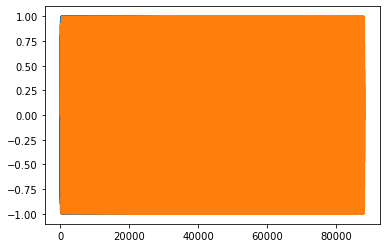

In [1102]:
# linear or log chirp

sec = 2
k = 1000 # around 10?
fl = 100
fu = 6000

t = np.linspace(0, sec, int(fs*sec))

ch_lin = chirp(t, f0=fl, f1=fu, t1=sec, method='linear') # can be linear, quadratic or logarithmic
ch_lin *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t))) /5 # /5 scale to match size of ofdm?
inv_ch_lin = np.flip(ch_lin)

# form of log chirp

ch_log = np.sin(2 * np.pi * fl * sec * (np.exp( t * (np.log(fu / fl) / sec)) -1) /np.log(fu / fl) )
ch_log *= (1-np.exp(-k*t))*(1-np.exp(-k*(sec-t)))
mod = np.exp(-t * np.log(fu / fl) / sec)
inv_ch_log = np.flip(ch_log)
plt.plot(inv_ch_log)

ch = ch_log
ch = np.tile(ch, 1) # repeat num chirps

T = 0.0 # delay
inv_ch = inv_ch_log
inv_ch = np.concatenate((np.zeros(int(T*fs)), inv_ch), axis=None) # time reverse and delay the chirp

plt.plot(ch)

In [1103]:
repeats = 100
repeat = np.tile(frame, repeats) # transmit repeated frames

Chirp 1 starts at: 44100 Chirp ends at:  132300   OFDM starts at:  176400
Distance between chirp end & OFDM start:  44100


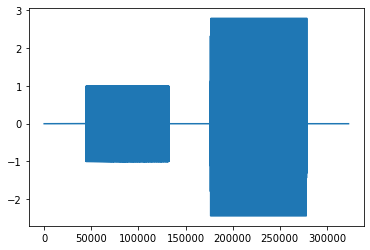

In [1104]:
gap = int(1*fs)
combined = np.concatenate((np.zeros(gap), ch, np.zeros(gap), repeat, np.zeros(gap)), axis=None)
print("Chirp 1 starts at:", gap, "Chirp ends at: ", gap+len(ch), "  OFDM starts at: ", (2*gap)+len(ch)) #, "Chirp 2 starts at: ", (3*gap)+len(ch)+len(repeat), "Dist between chirp starts: ", (2*gap)+len(ch)+len(repeat))
tx_diff = 2*gap + len(ch)
print("Distance between chirp end & OFDM start: ", gap)
plt.plot(combined)

7.321995464852607


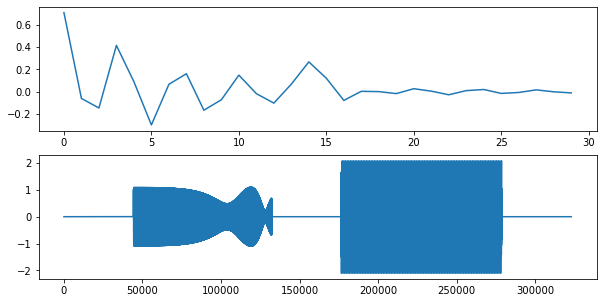

In [1137]:
#testing ideal channel

channel = np.genfromtxt('channel.csv',delimiter=',')
chan_fft = np.fft.fft(channel,N)
channel_op = np.convolve(combined, channel)

figs, axs = plt.subplots(2, 1, figsize=(10,5))
axs[1].plot(channel_op)
axs[0].plot(channel)
print(len(combined)/fs)

In [1118]:
####### OR for when using real channel

testing_real = True # check with ideal channel
# sync_chirptype_chirp reps_ofdm reps_gap_ch_len
if testing_real:
    sd.play(combined, fs)
    sf.write('sound_files/sync_log2_1_100_1_1_nocp.wav', combined, fs)

In [1202]:
if testing_real:
    seconds = np.ceil(len(combined)/fs) + 1 # record for a little longer than signal duration
    print(seconds)
    recording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
    sd.wait()

    sf.write('sound_files/sync_long_rec.wav', recording, fs)
    #plt.plot(recording)
    print("Done")
    channel_op = recording[:, 0] 

9.0
Done


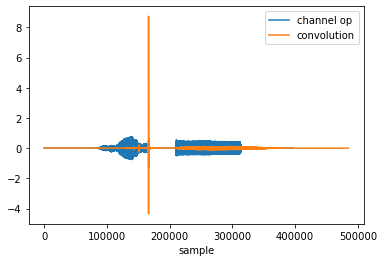

In [1203]:
conv = np.convolve(inv_ch, channel_op)
plt.plot(channel_op, label='channel op')
plt.plot(conv/1000, label='convolution')
plt.xlabel('sample')
plt.legend(loc='upper right')

Convolution peak 1: 166391
Side peaks:  86 30


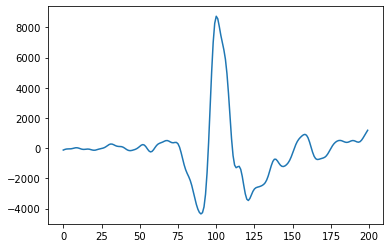

In [1204]:
peak1 = np.argmax(conv[0:int(len(conv)/2)]) # checks first half of convoluted signal for peak
#peak2 = np.argmax(conv[int(len(conv)/2):]) + int(len(conv)/2) + 0
print("Convolution peak 1:", peak1)
#print("Convolution peak 2:", peak2)
plt.plot(conv[peak1-100:peak1+100], label='peak 1') # zoom in on peak
#plt.plot(conv[peak2-100:peak2+100], label='peak 2')
#plt.legend()
#print("Dist: ", peak2 - peak1)
peak2 = np.argmax(conv[peak1+20:]) + 2
peak3 = peak1 - np.argmax(conv[0:peak1-20]) - 2
print("Side peaks: ", peak2, peak3)

1024
44130
Start:  210521
102400


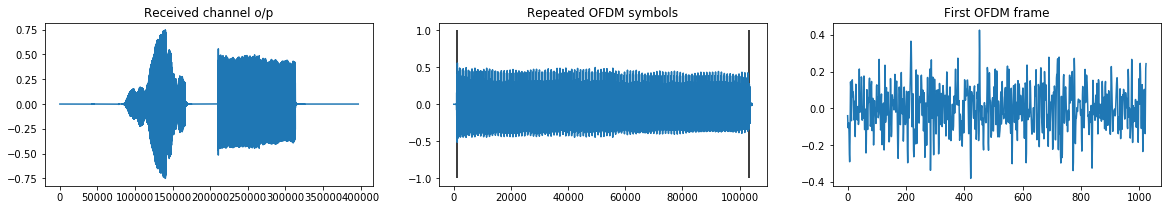

In [1214]:
# EXPERIMENT WITH CHANGING OFFSET TO SEE PHASE DIFFERENCE ON RECEIVED SYMBOLS

offset = 30 # current rough synchronisation error
print(len(frame))

rx_begin = peak1 + offset + gap - int(T*fs) # channel IR adjusts this value
print(rx_begin - peak1)
#rx_end = peak2 - gap - len(ch) - int(T*fs) + offset
print("Start: ", rx_begin) # , "End: ", rx_end, "Length: ", rx_end - rx_begin)
#extra = np.mod((rx_end-rx_begin), len(frame))

rx_OFDM = channel_op[rx_begin:rx_begin+len(repeat)] # for ideal sync

#rev_pulse = np.flip(pulse)
#rx_OFDM = np.convolve(rx_signal, rev_pulse)
single_frame = rx_OFDM[0:len(frame)]
print(len(rx_OFDM))
figs, axs = plt.subplots(1,3, figsize=(20, 3))

axs[0].set_title('Received channel o/p')
axs[0].plot(channel_op)
axs[1].set_title('Repeated OFDM symbols')
axs[1].plot(channel_op[rx_begin-1000:rx_begin+len(repeat)+1000])
axs[1].vlines([1000, len(repeat)+1000], -1, 1)
axs[2].set_title('First OFDM frame')
axs[2].plot(frame)


Diff:  34121


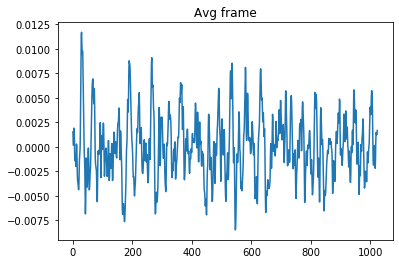

In [1215]:
frames = np.split(rx_OFDM, repeats)[1:-1] # ignore first & last frames?

avg_frame = np.zeros(len(frame))
for frame in frames:
    avg_frame = np.add(avg_frame, frame)
avg_frame /= repeats
#print(avg_frame)
plt.plot(avg_frame)
plt.title('Avg frame')
print("Diff: ", rx_begin - ((2*gap)+len(ch))) 

[2.75758711e+09+7.45388994e-20j 2.75758711e+09+1.08420217e-19j
 2.75758711e+09+9.48676901e-20j 2.75758711e+09+6.43745040e-20j
 2.75758711e+09+6.94567017e-20j 2.75758711e+09+8.30092288e-20j
 2.75758711e+09+1.40289832e-20j 2.75758711e+09+1.27054942e-20j
 2.75758711e+09-2.03287907e-20j 2.75758711e+09-4.74338450e-20j]


C:\Users\11kir\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in cdouble_scalars
  
C:\Users\11kir\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in cdouble_scalars
  


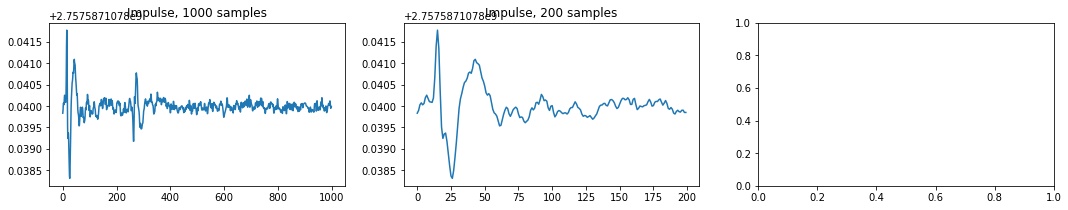

In [1216]:
# remove cp, reduce to info symbols only

trim_frame = avg_frame[prefix_no: prefix_no+N]

rx_dft = np.fft.fft(trim_frame, N) # get info symbols stored

#print(rx_dft[0], rx_dft[512])
#print(rx_dft[1], rx_dft[1023])

norm_rx_dft = []

for i in range(len(full_symbols)):
    #print(rx_dft[i], full_symbols[i], rx_dft[i] / full_symbols[i])
    norm_rx_dft = np.append(norm_rx_dft, rx_dft[i] / full_symbols[i])

#print(rx_dft[0], rx_dft[512])
#print(rx_dft[511], rx_dft[513])    

norm_rx_dft[512] = 0 # getting NaN otherwise

imp_response = np.fft.ifft(norm_rx_dft, N)

print(imp_response[0:10])
imp_response = np.real(imp_response)

figs, axs = plt.subplots(1, 3, figsize=(18,3))
axs[0].plot(imp_response[:1000])
axs[0].set_title('Impulse, 1000 samples')
axs[1].set_title('Impulse, 200 samples')
axs[1].plot(imp_response[:200])
#axs[2].plot(channel)

Text(0, 0.5, 'Magnitude of freq response')

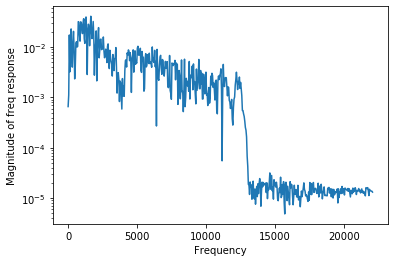

In [1217]:
plt.semilogy(np.linspace(0, fs//2, N//2 -1), abs(norm_rx_dft)[1:N//2])
plt.xlabel('Frequency')
plt.ylabel('Magnitude of freq response')
# stop transmitting in low freq bins?

Text(0, 0.5, 'Phase of freq response')

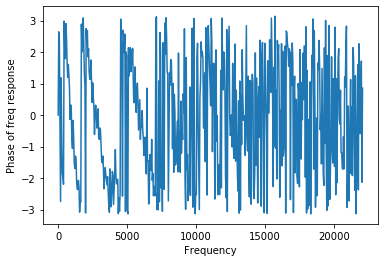

In [1218]:
phase = np.angle(norm_rx_dft)[:N//2]
plt.plot(np.linspace(0, fs/2, len(phase)), phase)
plt.xlabel('Frequency')
plt.ylabel('Phase of freq response')
# will change for sampling freq offset?